In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
import netCDF4
import cf

<xarray.DataArray 'UM_m01s00i216_vn900' ()>
array(79600935660)


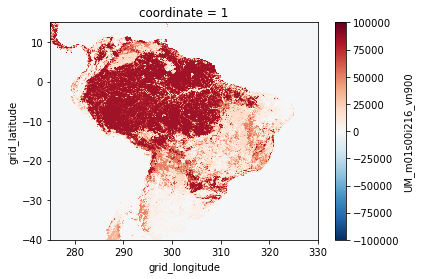

In [2]:
igbp=cf.read("qrparm.veg.frac_igbp")
cci=cf.read("qrparm.veg.frac.cci")
cf.write(igbp, 'qrparm.veg.frac.igbp.nc')
cf.write(cci, 'qrparm.veg.frac.cci.nc')

cci_data = xr.open_dataset('qrparm.veg.frac.cci.nc',decode_times=False)
igbp_data = xr.open_dataset('qrparm.veg.frac.igbp.nc',decode_times=False)

# matches dimension labels - *very* dataset specific (check before using)
cci_data = cci_data.rename({'longitude':'grid_longitude','latitude':'grid_latitude'})

# convert to integer, as it all falls apart otherwise
cci_data['UM_m01s00i216_vn405'] = cci_data.UM_m01s00i216_vn405 * 100000
igbp_data['UM_m01s00i216_vn900'] = igbp_data.UM_m01s00i216_vn900 * 100000

cci_data['UM_m01s00i216_vn405'] = cci_data.UM_m01s00i216_vn405.astype('int')
igbp_data['UM_m01s00i216_vn900'] = igbp_data.UM_m01s00i216_vn900.astype('int')

# set no data as -999
cci_data['UM_m01s00i216_vn405'] = xr.where(cci_data.UM_m01s00i216_vn405<-1000, -999, cci_data.UM_m01s00i216_vn405)
igbp_data['UM_m01s00i216_vn900'] = xr.where(igbp_data.UM_m01s00i216_vn900<-1000, -999, igbp_data.UM_m01s00i216_vn900)

#igbp_data
#cci_data
igbp_data.UM_m01s00i216_vn900[0,:,:].plot()
print(igbp_data.UM_m01s00i216_vn900.sum())

In [3]:
#igbp_data
#igbp_data.UM_m01s00i216_vn900[:,500,500]
#print(igbp_data.UM_m01s00i216_vn900[:,500,500].sum(dim="coordinate"))

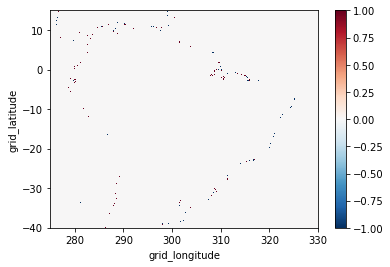

In [4]:
# create masks
cci_mask = cci_data.UM_m01s00i216_vn405.sum(dim='coordinate')
igbp_mask = igbp_data.UM_m01s00i216_vn900.sum(dim='coordinate')

igbp_mask = xr.where(igbp_mask>0, 1, 0)
cci_mask = xr.where(cci_mask>0, -1, 0)

#cci_mask.plot()

master_mask = igbp_mask + cci_mask
master_mask.plot()

<xarray.DataArray ()>
array(79339927808)


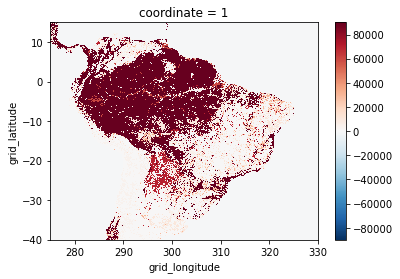

In [5]:
# remove cci points that don't exist in igbp
cci_match = xr.where(master_mask == 0, cci_data.UM_m01s00i216_vn405, -999)
print(cci_match.sum(dim='coordinate').sum())
cci_match[:,:,0].plot()

<xarray.DataArray ()>
array(240693894)


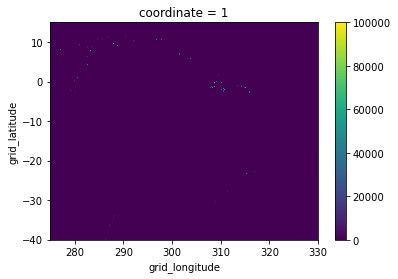

In [6]:
# add igbp points that don't exist in cci
cci_nonmatch = xr.where(master_mask == 1, igbp_data.UM_m01s00i216_vn900, 0)
print(cci_nonmatch.sum(dim='coordinate').sum())
cci_nonmatch[:,:,0].plot()

<xarray.DataArray ()>
array(88293521081)


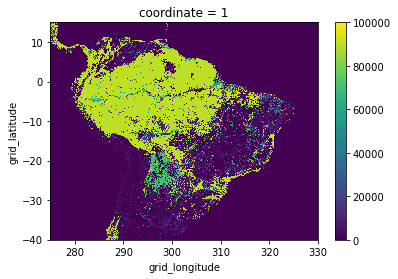

In [7]:
# add these two new masked igbp and cci datasets together
cci_match = xr.where(cci_match<0, 0, cci_match)
new_data = cci_match + cci_nonmatch
new_data[:,:,0].plot()
print(new_data.sum())

<xarray.DataArray ()>
array(88293521081)
<xarray.Dataset>
Dimensions:               ()
Data variables:
    grid_latitude_bounds  float64 -1.981e+08
    bounds                float64 4.763e+09
    latitude_bounds       float64 -3.963e+08
    bounds_1              float64 -1.918e+09
    UM_m01s00i216_vn900   int64 88292193702


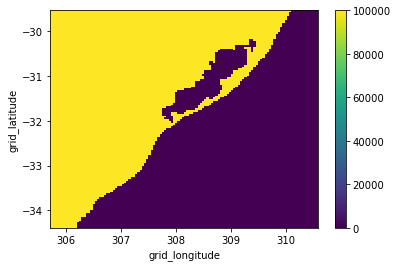

In [8]:
# check everything adds up and compare with igbp data
new_data[140:260,760:880,:].sum(dim="coordinate").plot()
print(new_data.sum())
test = xr.where(igbp_data.UM_m01s00i216_vn900<0, 0, igbp_data)
print(test.sum())

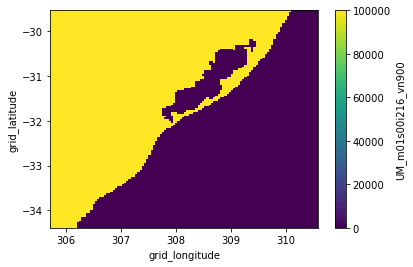

In [9]:
test.UM_m01s00i216_vn900[:,140:260,760:880].sum(dim="coordinate").plot()

In [ ]:
# sum integers to 100000, quite a few are 99999, takes a ~30mins
# adds or deletes the missing 1 which is actually 0.00001 to the largest category for each cell
count = 0

for x in range(1360):
    print(x)
    for y in range(1360):
        
#for x in range(140,180):
#    for y in range(660,700):        
        tmp = new_data[x,y,:].sum(dim='coordinate', skipna=False)
        if tmp != 100000 and tmp != 0 and tmp.isnull() == False:
            count = count + 1
            #print(x,y)
            tmp2=new_data[x,y,:]
            tmp2=np.argmax(tmp2.data)
            new_data[x,y,tmp2] = new_data[x,y,tmp2] + (100000 - tmp)
            
print("final count = ",count)
int_data = new_data # copying just in case
new_data = new_data/100000
print(new_data.sum())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#new_data[:,:,0].plot()

In [ ]:
# check if count matches with qrparm.mask created by the um

um_mask=cf.read("qrparm.mask_igbp")
cf.write(um_mask, 'um_mask.nc')
um_mask = xr.open_dataset('um_mask.nc',decode_times=False)
                     
print(um_mask.UM_m01s00i030_vn900.sum())
print(new_data.sum())
test = um_mask.UM_m01s00i030_vn900 - new_data.sum(dim="coordinate")
print(test.sum())

In [ ]:
#um_mask.UM_m01s00i030_vn900[140:260,760:880].plot()

In [ ]:
# set no data to nan
new_data = xr.where(new_data.sum(dim="coordinate") == 0, np.nan, new_data)
new_data = new_data.transpose("coordinate", "grid_latitude", "grid_longitude")

# sort the rotated lon by putting the new_data into the um_mask file that already has the right rlon attributes
# could also use the original igbp file
um_mask['field_1391'] = new_data
um_mask.field_1391.attrs['grid_mapping'] = 'rotated_latitude_longitude'

In [ ]:
# write out
#new_data.to_netcdf(path='cci_with_igbp_fill_surface_fractions.nc',format='NETCDF4_CLASSIC')
um_mask.to_netcdf(path='cci_with_igbp_fill_surface_fractions2.nc',format='NETCDF4_CLASSIC')

In [ ]:
# next use xancil on archer2 to convert to UM ancillary format